In [ ]:
# FPAge
# © 2024 - Ron Raisch - HUJI
# Licensed under the FPAge License (see LICENSE file for details).
# For commercial inquiries, contact fpagedata@gmail.com

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from ML.preprocess.SMOTE import generate_new_samples
from ML.standarts import RANDOM_STATE
from preprocess.main import main as preprocess_main

In [2]:
# change the working directory to the root of the project
if os.path.basename(os.getcwd()) == 'ML':
    os.chdir('..')

In [3]:
assert os.path.basename(os.getcwd()) == 'FPAge', 'The working directory should be the root of the project'

In [4]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_main(include_val=True, use_pca=True)

Loaded dataset from ML/datasets/dataset_add_features_True.feather in 0.37 seconds


In [5]:
X_train.shape, X_val.shape, X_test.shape

((592, 591), (79, 591), (73, 591))

/var/folders/hm/y24_51v94jj_qlbxgg2t7kmw0000gn/T/ipykernel_83751/3938833839.py:4: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  target_entropy = -np.sum(np.bincount(y_train) / len(y_train) * np.log2(np.bincount(y_train) / len(y_train)))


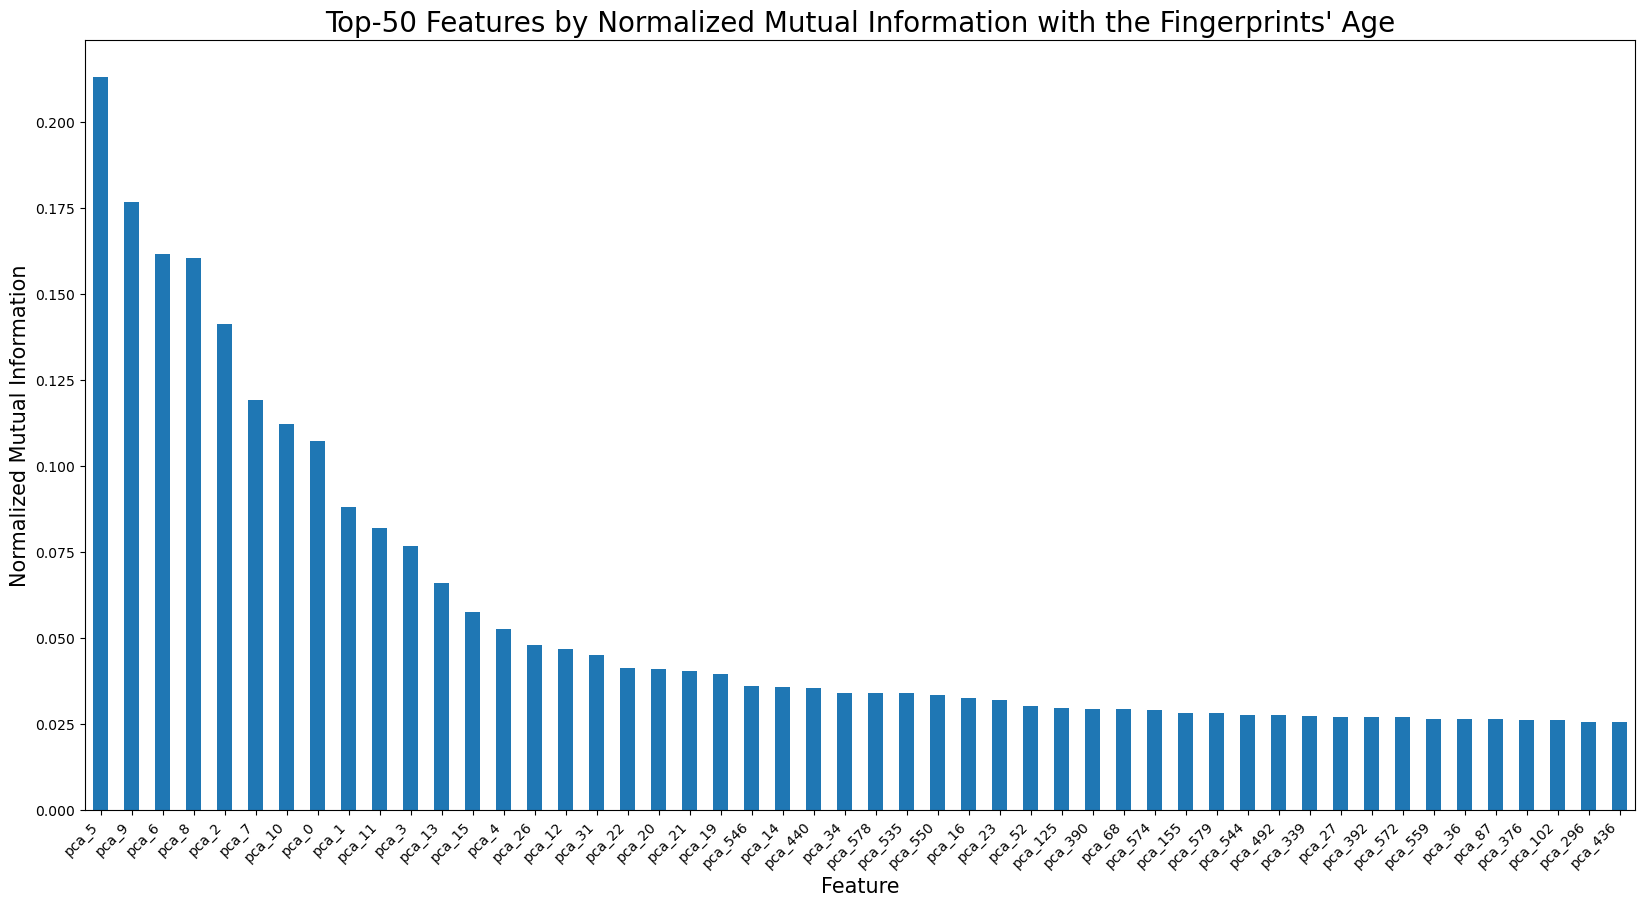

In [6]:
# measure the mutual information between the features and the target
mi = mutual_info_regression(X_train, y_train)
# normalize the mutual information relative to the entropy of the target
target_entropy = -np.sum(np.bincount(y_train) / len(y_train) * np.log2(np.bincount(y_train) / len(y_train)))
mi /= target_entropy


mi_df = pd.DataFrame(mi, index=X_train.columns, columns=['mi']).sort_values(by='mi', ascending=False)


mi_df[:50].plot(kind='bar', figsize=(20, 10))
plt.xticks(rotation=45, ha='right')
plt.title('Top-50 Features by Normalized Mutual Information with the Fingerprints\' Age', fontsize=20)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Normalized Mutual Information', fontsize=15)
# remove legend
plt.gca().get_legend().remove()

In [7]:
selected_features = mi_df.sort_values(by='mi', ascending=False).index[:30]

In [8]:
X_train, X_val, X_test = X_train[selected_features], X_val[selected_features], X_test[selected_features]
X_train.shape

(592, 30)

In [9]:
tsne = TSNE(n_components=2, perplexity=10, random_state=RANDOM_STATE)
X_embedded = tsne.fit_transform(X_train)
X_embedded.shape

(592, 2)

In [10]:
# use KNN to find the nearest neighbors of each point and evaluate the r2 score of the model 
# using leave one out cross validation

loo = LeaveOneOut()
knn_errors = []
for train_index, test_index in loo.split(X_embedded):
    knn = KNeighborsRegressor(n_neighbors=8, n_jobs=-1)

    X_train_loo, X_test_loo = X_embedded[train_index], X_embedded[test_index]
    y_train_loo, y_test_loo = y_train.iloc[train_index], y_train.iloc[test_index]
    knn.fit(X_train_loo, y_train_loo)
    y_pred_loo_knn = knn.predict(X_test_loo)
    knn_errors.append(np.abs(y_pred_loo_knn - y_test_loo).astype(float))

knn_errors = np.array(knn_errors).flatten()

# get errors of a dummy model that predicts the mean of the target
mean_errors = np.abs(y_train - y_train.mean())

knn_error_squared = knn_errors ** 2
mean_errors_squared = mean_errors ** 2

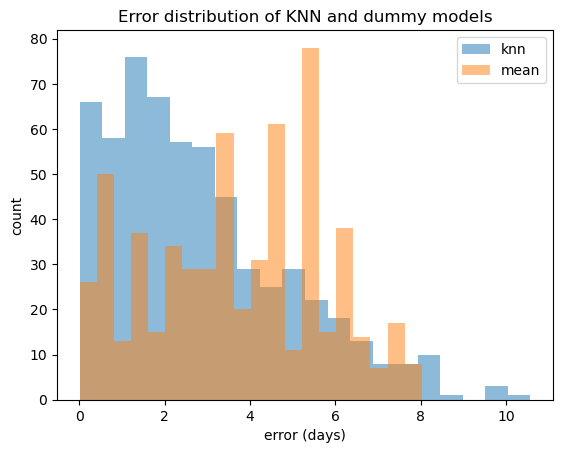

In [11]:
plt.hist(knn_errors, bins=20, alpha=0.5, label='knn')
plt.hist(mean_errors, bins=20, alpha=0.5, label='mean')
plt.xlabel('error (days)')
plt.ylabel('count')
plt.title('Error distribution of KNN and dummy models')
plt.legend()

In [12]:
print(f'KNN mean error: {knn_errors.mean():.3f}, Mean error: {mean_errors.mean():.3f}')

knn_rmse = np.sqrt(knn_error_squared.mean())
mean_rmse = np.sqrt((mean_errors_squared).mean())
print(f'KNN RMSE: {knn_rmse:.3f}, Mean RMSE: {mean_rmse:.3f}')

r2 = 1 - (knn_error_squared.sum() / mean_errors_squared.sum())
print(f'R^2 of KNN: {r2:.3f}')

knn_median_error = np.median(knn_errors)
mean_median_error = np.median(mean_errors)
print(f'KNN median error: {knn_median_error:.3f}, Mean median error: {mean_median_error:.3f}')

knn_80th_percentile = np.quantile(knn_errors, 0.8)
mean_80th_percentile = np.quantile(mean_errors, 0.8)
print(f'KNN 80th percentile: {knn_80th_percentile:.3f}, Mean 80th percentile: {mean_80th_percentile:.3f}')

knn_90th_percentile = np.quantile(knn_errors, 0.9)
mean_90th_percentile = np.quantile(mean_errors, 0.9)
print(f'KNN 90th percentile: {knn_90th_percentile:.3f}, Mean 90th percentile: {mean_90th_percentile:.3f}')

KNN mean error: 2.839, Mean error: 3.711
KNN RMSE: 3.526, Mean RMSE: 4.233
R^2 of KNN: 0.306
KNN median error: 2.386, Mean median error: 3.661
KNN 80th percentile: 4.599, Mean 80th percentile: 5.491
KNN 90th percentile: 5.905, Mean 90th percentile: 6.289


In [13]:
# Not using PCA this time
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_main(include_val=True, use_pca=False)

Loaded dataset from ML/datasets/dataset_add_features_True.feather in 0.27 seconds


In [14]:
X_train.shape, X_val.shape, X_test.shape

((592, 17961), (79, 17961), (73, 17961))

/var/folders/hm/y24_51v94jj_qlbxgg2t7kmw0000gn/T/ipykernel_83751/239217002.py:4: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  target_entropy = -np.sum(np.bincount(y_train) / len(y_train) * np.log2(np.bincount(y_train) / len(y_train)))


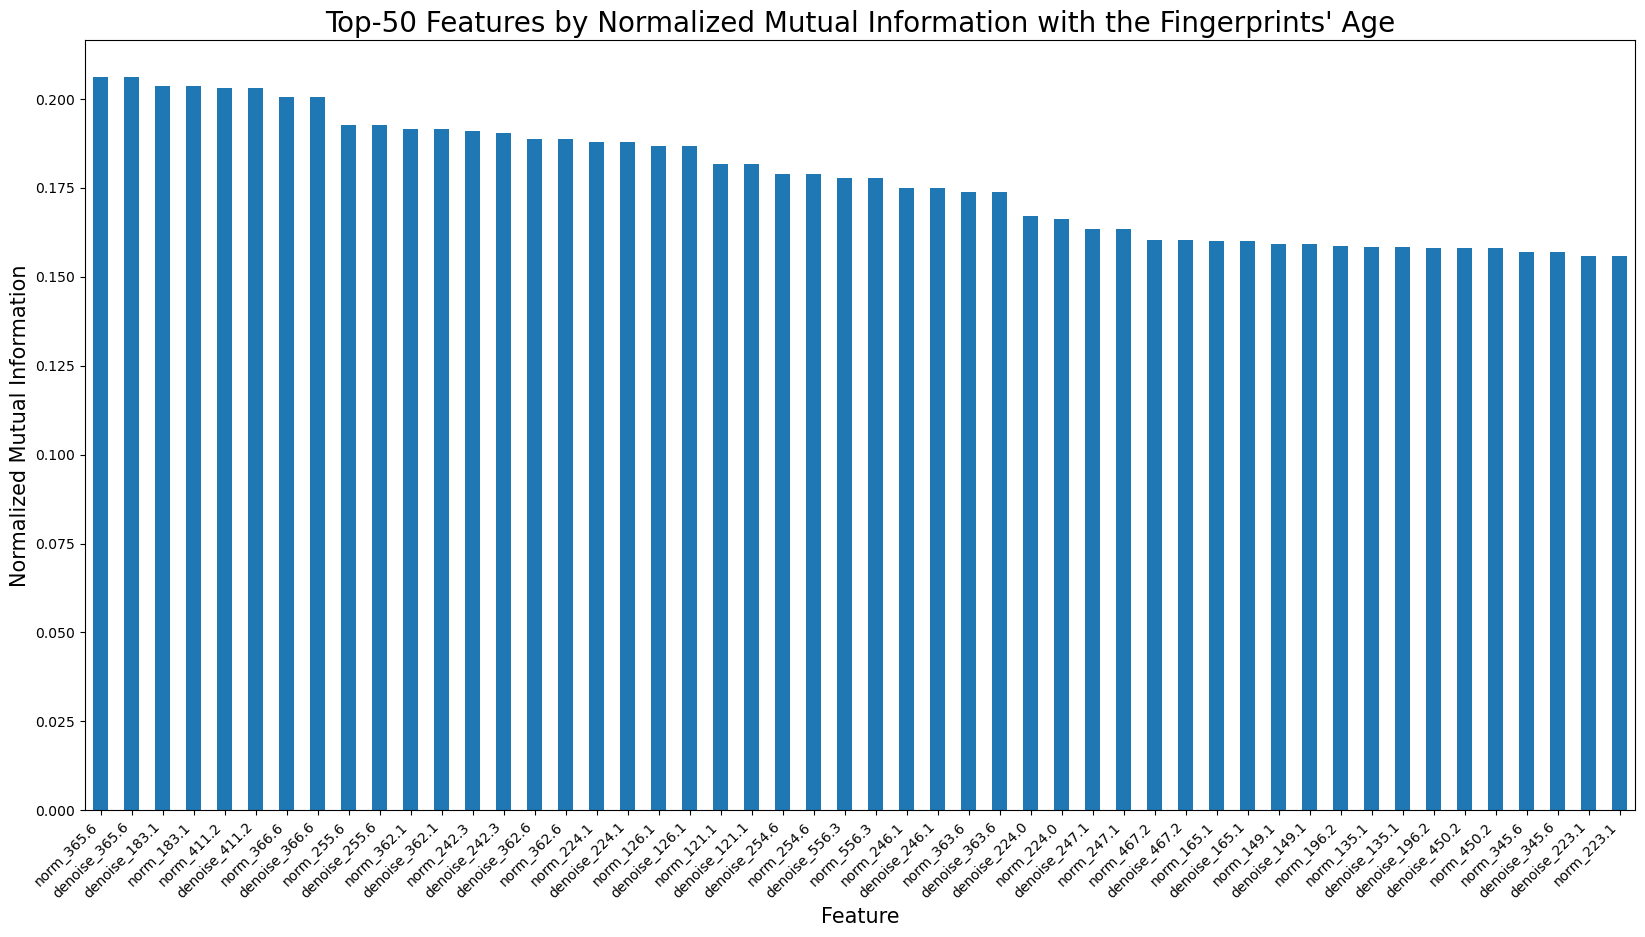

In [31]:
# measure the mutual information between the features and the target
mi = mutual_info_regression(X_train, y_train)
# normalize the mutual information relative to the entropy of the target
target_entropy = -np.sum(np.bincount(y_train) / len(y_train) * np.log2(np.bincount(y_train) / len(y_train)))
mi /= target_entropy

mi_df = pd.DataFrame(mi, index=X_train.columns, columns=['mi']).sort_values(by='mi', ascending=False)

mi_df[:50].plot(kind='bar', figsize=(20, 10))
plt.xticks(rotation=45, ha='right')
plt.title('Top-50 Features by Normalized Mutual Information with the Fingerprints\' Age', fontsize=20)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Normalized Mutual Information', fontsize=15)
# remove legend
plt.gca().get_legend().remove()
selected_features = mi_df.sort_values(by='mi', ascending=False).index[:200]

In [32]:
syn_x, syn_y = generate_new_samples(X_train, y_train, k=5, m=3, num_of_samples=5000, alpha_lim=0.2)
syn_x.shape

(5000, 17961)

In [33]:
num_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
max_depths = [1, 2, 3, 4, 5]
results = {}

for num_estimator in num_estimators:
    for max_depth in max_depths:
        model = XGBRegressor(max_depth=max_depth, n_estimators=num_estimator, n_jobs=-1, random_state=RANDOM_STATE).fit(syn_x[selected_features], syn_y)
        X_val.index = y_val.index
        r2 = model.score(X_val[selected_features], y_val)
        pearson = stats.pearsonr(y_val, model.predict(X_val[selected_features]))[0]
        results[(num_estimator, max_depth)] = (r2, pearson)
        print(f'num_estimators: {num_estimator}, max_depth: {max_depth}, r2: {r2}, pearson: {pearson}')

num_estimators: 10, max_depth: 1, r2: 0.11348672375250768, pearson: 0.4298500236067035
num_estimators: 10, max_depth: 2, r2: 0.12828447857094027, pearson: 0.45811664126686974
num_estimators: 10, max_depth: 3, r2: 0.050704909766832285, pearson: 0.35753775710644303
num_estimators: 10, max_depth: 4, r2: 0.10302849578745255, pearson: 0.4149847584185263
num_estimators: 10, max_depth: 5, r2: 0.025185689931667588, pearson: 0.3371243368850703
num_estimators: 20, max_depth: 1, r2: 0.12085095113029709, pearson: 0.461435419617969
num_estimators: 20, max_depth: 2, r2: 0.19837489303893185, pearson: 0.5395981618045408
num_estimators: 20, max_depth: 3, r2: 0.06067689829576284, pearson: 0.41130403099875384
num_estimators: 20, max_depth: 4, r2: 0.1530649907550865, pearson: 0.49890017205207665
num_estimators: 20, max_depth: 5, r2: 0.03077239339352511, pearson: 0.3664893137366135
num_estimators: 30, max_depth: 1, r2: 0.15752657608177834, pearson: 0.5151473793028579
num_estimators: 30, max_depth: 2, r2: 0

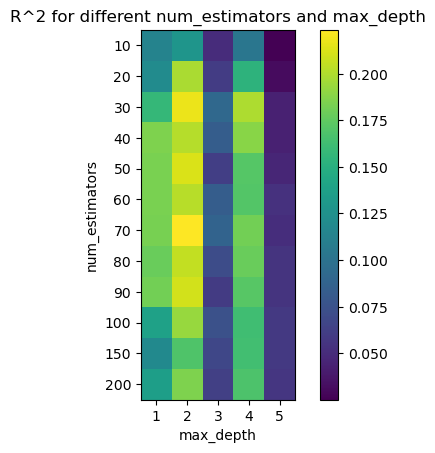

In [34]:
# plot the R^2 of the model with and without outliers as a heatmap for num_estimators and threshold from results dict
r2 = np.zeros((len(num_estimators), len(max_depths)))
for i, num_estimator in enumerate(num_estimators):
    for j, max_depth in enumerate(max_depths):
        r2[i, j] = results[(num_estimator, max_depth)][0]

plt.figure()
plt.imshow(r2, cmap='viridis', interpolation='nearest')
# use max_depth as x axis and num_estimators as y axis
plt.xticks(range(len(max_depths)), max_depths)
plt.yticks(range(len(num_estimators)), num_estimators)
plt.colorbar()
plt.xlabel('max_depth')
plt.ylabel('num_estimators')
plt.title(f'R^2 for different num_estimators and max_depth')
plt.show()

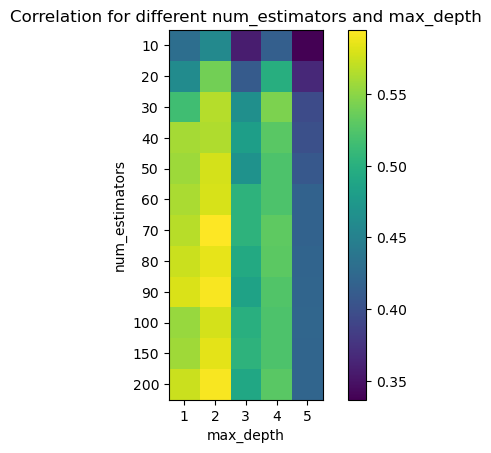

In [35]:
# plot the correlation of the model with and without outliers as a heatmap for num_estimators and max_depths from results dict

correlation = np.zeros((len(num_estimators), len(max_depths)))
for i, num_estimator in enumerate(num_estimators):
    for j, max_depth in enumerate(max_depths):
        correlation[i, j] = results[(num_estimator, max_depth)][1]
        
plt.figure()
plt.imshow(correlation, cmap='viridis', interpolation='nearest')
# use max_depth as x axis and num_estimators as y axis
plt.xticks(range(len(max_depths)), max_depths)
plt.yticks(range(len(num_estimators)), num_estimators)
plt.colorbar()
plt.xlabel('max_depth')
plt.ylabel('num_estimators')
plt.title(f'Correlation for different num_estimators and max_depth')
plt.show()

correlation: 0.50, p-value: 8.0e-06


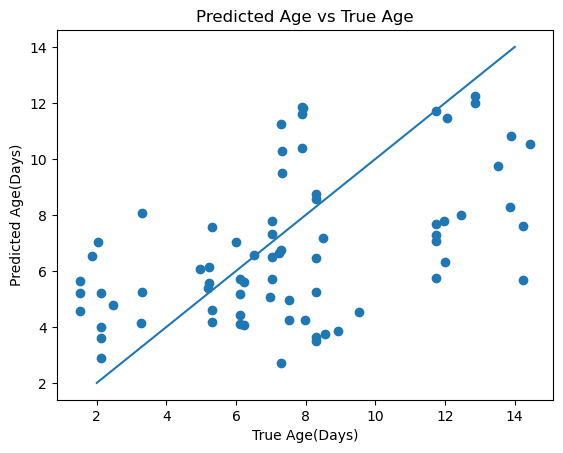

In [42]:
model = XGBRegressor(max_depth=2, n_estimators=70, n_jobs=-1, random_state=RANDOM_STATE).fit(syn_x[selected_features], syn_y)
y_pred = model.predict(X_test[selected_features])
plt.scatter(y_test, y_pred, alpha=1)
plt.plot([2, 14], [2, 14])
plt.xlabel('True Age(Days)')
plt.ylabel('Predicted Age(Days)')

plt.title('Predicted Age vs True Age')
pearson = stats.pearsonr(y_test, model.predict(X_test[selected_features]))
print(f'correlation: {pearson[0]:.2f}, p-value: {pearson[1]:.1e}')

# plt.axhline(7, color='r', linestyle='--', label='7 days')
# plt.axvline(4, color='g', linestyle='--', label='4 days')
# plt.axvline(10, color='g', linestyle='--', label='10 days')

In [43]:
y_test_limited = y_test[(y_test < 4) | (y_test > 10)]
y_test_limited = np.where(y_test_limited < 4, 0, 1)

y_pred_limited = y_pred[(y_test < 4) | (y_test > 10)]
y_pred_limited = np.where(y_pred_limited < 7, 0, 1)

In [46]:
# calculate the accuracy of the model
accuracy = np.mean(y_test_limited == y_pred_limited)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.833


Text(0, 0.5, 'True')

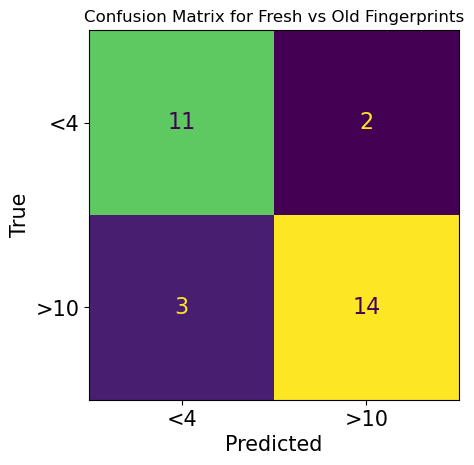

In [45]:
# plot confusion matrix
cm = confusion_matrix(y_test_limited, y_pred_limited)
# make the font size bigger in the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<4', '>10'])
disp.plot(colorbar=False)
plt.title('Confusion Matrix for Fresh vs Old Fingerprints')

for text in disp.text_.ravel():
    text.set_fontsize(16)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)